[Notebook of task](https://github.com/DistributedSystemsGroup/Algorithmic-Machine-Learning/blob/master/Challenges/Anomaly_Detection/anomaly_detection_challenge.ipynb)

In [20]:
!pip3 install --user 'scikit-multilearn' 

    100% |################################| 92kB 964kB/s 
You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm

warnings.filterwarnings('ignore')

basepath = "/mnt/datasets/anomaly/"

In [2]:
from names import column_names, labels

In [3]:
dataDF = pd.read_csv(basepath + 'data.csv', delimiter=";", header=None, names=column_names)

In [4]:
# create pure data DF
puredataDF = dataDF.drop(labels, axis=1)

#create a copy of the label columns for exploration
anomaliesDF = dataDF.filter(labels, axis=1)

# percentage of NA in each label 

print(anomaliesDF.isna().mean().round(4) * 100) 


Check1     8.54
Check2     8.53
Check3     7.86
Check4    12.77
Check5    12.21
Check6     2.57
Check7    12.45
Check8     0.02
dtype: float64


The different labels have a lot of NaN values. Should these be removed? Or should we handle each label individually and only use the rows without NaNs for that label? The simplest solution is to fill them with 0's.

In [5]:
anomaliesDF_with_zerNA = anomaliesDF.fillna(0) # Fill NaNs with 0s, considering them as "not an anomaly"
anomaliesDF_with_negNA = anomaliesDF.fillna(-1) # Fill NaNs with -1 considering them as a separate class for the classifier.
puredataDF_with_negNA = puredataDF.fillna(-1)

Text(0.5,1,'Corrolation matrix of the 8 different checks')

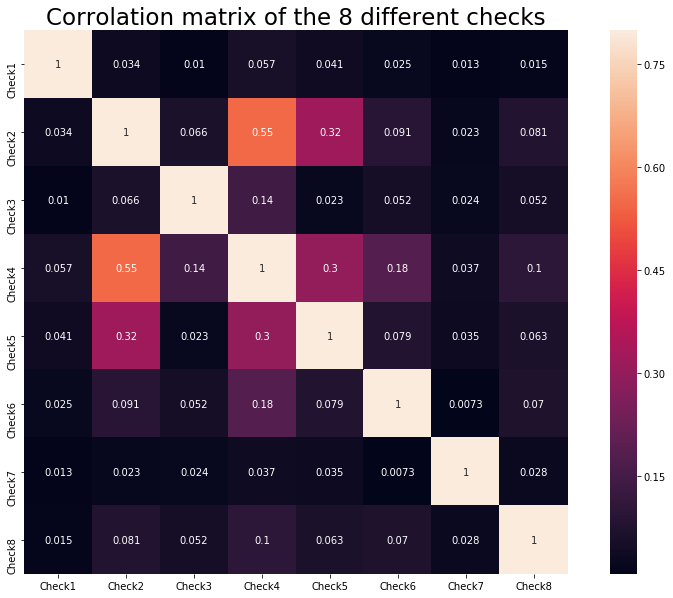

In [6]:
#sns.set(font_scale=1.3)

corr_matrix_anomalies = anomaliesDF.corr()
figure, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix_anomalies, vmax=0.8, annot=True, square=True)
plt.title('Corrolation matrix of the 8 different checks', fontsize=23)


### Things to note from corr matrix of the different labels
- Check4 and Check2 have a corrolation of 0.55. It could be wise to make one model to predict these two together.
- Check5 and Check2 have a corrolation of 0.32
- Check5 and Check4 have a corrolation of 0.3
- Maybe all three together?

In [7]:
#counted_anomaliesDF = anomaliesDF_withoutNA.apply(pd.value_counts)
counted_anomaliesDF = anomaliesDF.apply(pd.value_counts)

In [8]:
counted_anomaliesDF.loc["Total"] = counted_anomaliesDF.sum()
counted_anomaliesDF.loc["PercentageAnomalies"] = (counted_anomaliesDF.iloc[1] / counted_anomaliesDF.iloc[2]).round(5)*100


In [9]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
counted_anomaliesDF

,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0.0,260884.00,253781.00,256370.00,225569.00,248917.00,199075.00,243621.00,284060.00
1.0,1636.00,8764.00,8093.00,24815.00,3080.00,80572.00,7688.00,2919.00
Total,262520.00,262545.00,264463.00,250384.00,251997.00,279647.00,251309.00,286979.00
PercentageAnomalies,0.62,3.34,3.06,9.91,1.22,28.81,3.06,1.02


In [10]:
'''names = []

for row in anomaliesDF_with_negNA.itertuples():
    l = []
    if row.Check1 == 1:
        l.append("Check1")
    if row.Check2 == 1:
        l.append("Check2")
    if row.Check3 == 1:
        l.append("Check3")
    if row.Check4 == 1:
        l.append("Check4")
    if row.Check5 == 1:
        l.append("Check5")
    if row.Check6 == 1:
        l.append("Check6")
    if row.Check7 == 1:
        l.append("Check7")
    if row.Check8 == 1:
        l.append("Check8")
    names.append(l)

    
plotDF = anomaliesDF_withoutNA
plotDF['Names'] = names'''

'names = []\n\nfor row in anomaliesDF_with_negNA.itertuples():\n    l = []\n    if row.Check1 == 1:\n        l.append("Check1")\n    if row.Check2 == 1:\n        l.append("Check2")\n    if row.Check3 == 1:\n        l.append("Check3")\n    if row.Check4 == 1:\n        l.append("Check4")\n    if row.Check5 == 1:\n        l.append("Check5")\n    if row.Check6 == 1:\n        l.append("Check6")\n    if row.Check7 == 1:\n        l.append("Check7")\n    if row.Check8 == 1:\n        l.append("Check8")\n    names.append(l)\n\n    \nplotDF = anomaliesDF_withoutNA\nplotDF[\'Names\'] = names'

Text(0.5,1,'Number of observations with one or more anomaly')

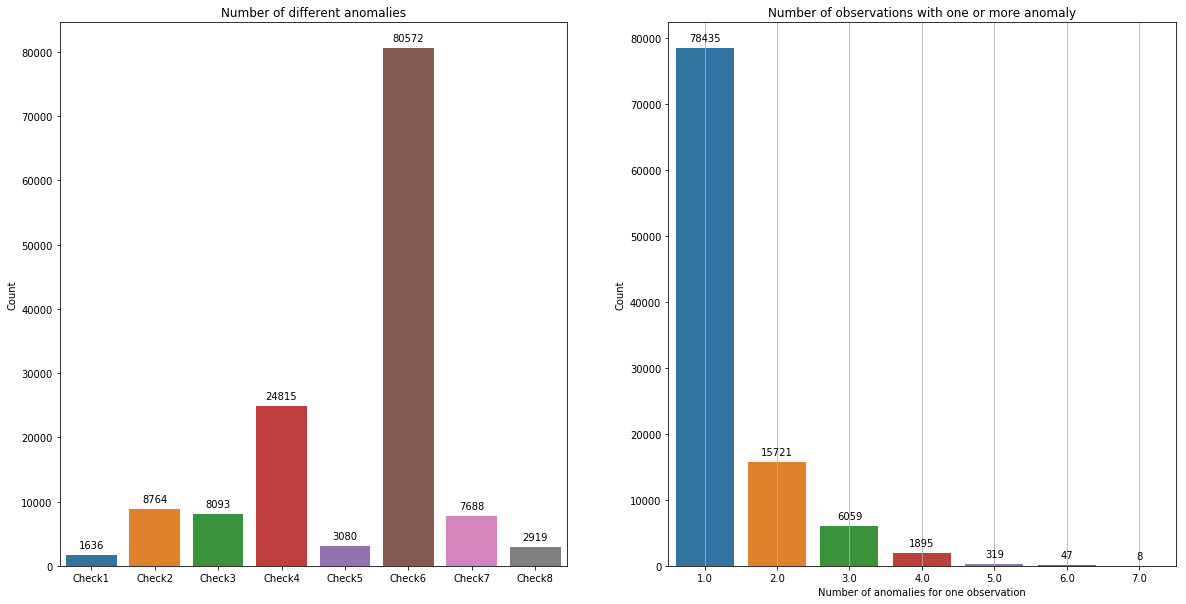

In [11]:
y1 = counted_anomaliesDF.loc[1.0]
x1 = labels

rowSums = dataDF.iloc[:,36:].sum(axis=1)
rowSums = rowSums.value_counts()
multiLabel_counts = rowSums[1:]

figure = plt.figure(figsize=(20,10))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

b1 = sns.barplot(y=y1, x=x1, ax=ax1)
plt.grid()

for p in b1.patches:
    b1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

b2 = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values, ax=ax2)
plt.grid()

for p in b2.patches:
    b2.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax1.set_ylabel('Count')
ax1.set_title('Number of different anomalies')

ax2.set_xlabel('Number of anomalies for one observation')
ax2.set_ylabel('Count')
ax2.set_title('Number of observations with one or more anomaly')

## Exploration of data (not labels)

In [12]:
# percentage of NA in each label 
print(puredataDF.isna().mean().round(4) * 100) 

SessionNumber                            0.00
SystemID                                 0.00
Date                                     0.00
HighPriorityAlerts                       0.00
Dumps                                    0.00
CleanupOOMDumps                          0.00
CompositeOOMDums                         0.00
IndexServerRestarts                      0.00
NameServerRestarts                       0.00
XSEngineRestarts                         0.00
PreprocessorRestarts                     0.00
DaemonRestarts                           0.00
StatisticsServerRestarts                 0.00
CPU                                      8.78
PhysMEM                                  7.17
InstanceMEM                              7.71
TablesAllocation                         0.80
IndexServerAllocationLimit               9.21
ColumnUnloads                            0.00
DeltaSize                                0.07
MergeErrors                              2.69
BlockingPhaseSec                  

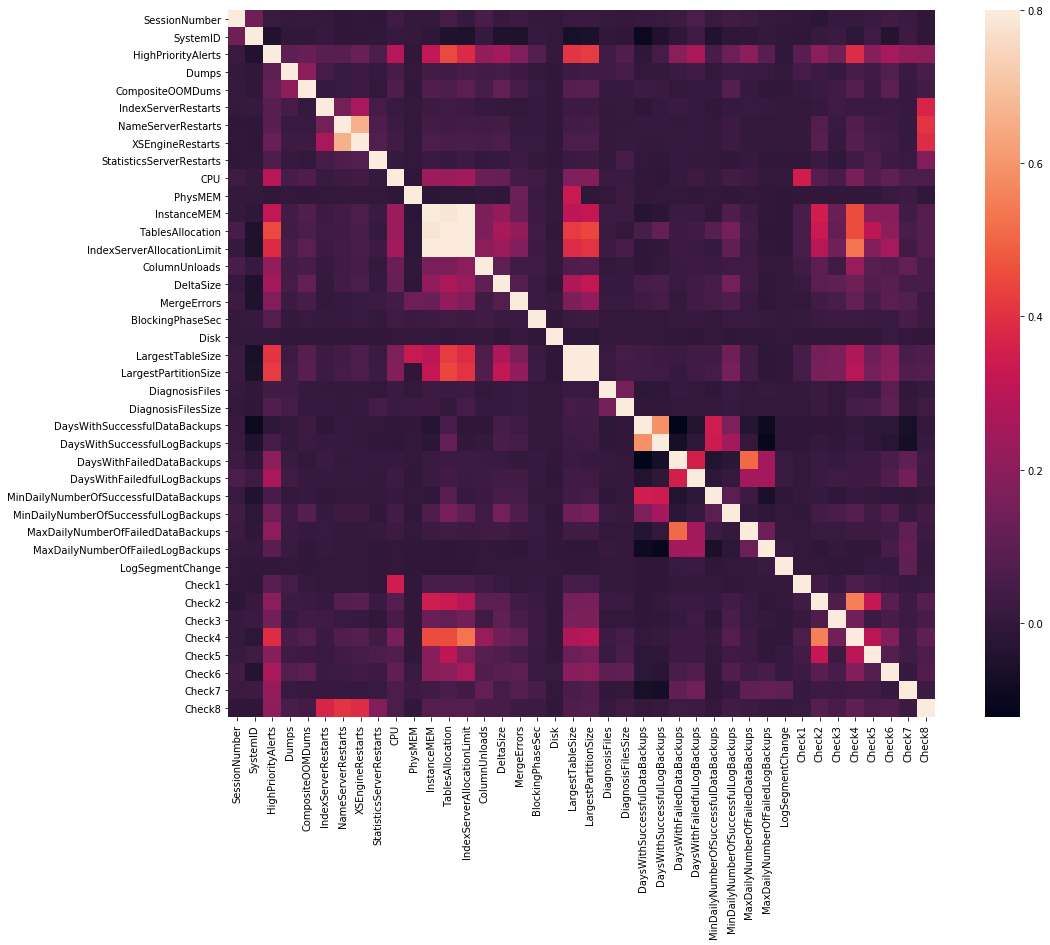

In [13]:

matrixDF = dataDF.drop(["CleanupOOMDumps","PreprocessorRestarts", "DaemonRestarts"], axis=1) # gives problem with 
corr_matrix_puredata = matrixDF.corr()
figure, ax = plt.subplots(figsize=(18,13))
ax = sns.heatmap(corr_matrix_puredata, vmax=0.8, square=True)


# Data preprocessing

In [14]:
# All the different dataset in the Notebook

# puredataDF               : only data columns with NA cells
# anomaliesDF              : only label columns with NA cells
# anomaliesDF_with_zerNA   : only label columns with NA cells =0
# anomaliesDF_with_negNA   : only label columns with NA cells =-1
# puredataDF_with_negNA    : only data columns with NA cells =-1



# Removal
puredataDF.drop(['CleanupOOMDumps', 'PreprocessorRestarts', 'DaemonRestarts'], axis=1, inplace=True)

# Direct recasting
direct_recast = ['Dumps', 'CompositeOOMDums', 'DeltaSize', 'MergeErrors', 'BlockingPhaseSec', 
                 'LargestTableSize', 'LargestPartitionSize', 'DiagnosisFiles', 'DiagnosisFilesSize', 
                 'LogSegmentChange']
for column in direct_recast:
    puredataDF[column] = puredataDF[column].astype(np.int64, errors='ignore')

#Format recasting
format_recast = ['CPU', 'PhysMEM', 'InstanceMEM', 'TablesAllocation', 'IndexServerAllocationLimit', 
                    'Disk']
for column in format_recast:
    puredataDF[column] = 100*puredataDF[column]
    puredataDF[column] = puredataDF[column].astype(np.int64, errors='ignore')
    


# Drop date object to be able to use PCA
puredataDF_withoutDate = puredataDF.drop("Date", axis=1)
puredataDF_with_negNA_withoutDate = puredataDF_with_negNA.drop("Date", axis=1)



#### Function to divide data into a binary classification problem

In [15]:
def create_binary_classification(puredataDF, anomaliesDF, label):
    y = anomaliesDF[label]
    indices_nan_labels = list(y.index[y.isnull()])
    
    X_mod = puredataDF.drop(indices_nan_labels, axis=0)
    y_mod = y.drop(indices_nan_labels)
    
    X_mod = X_mod.reset_index().drop("index", axis=1)
    y_mod = y_mod.reset_index().drop("index", axis=1)
    return X_mod, y_mod


#### Function to divide data into a multi-label problem

In [53]:
def create_multi_label(puredataDF, anomaliesDF):
    y = anomaliesDF
    y = y.astype(int)
    X = puredataDF
    return X, y

In [ ]:
#X, y = create_binary_classification(puredataDF_with_negNA_withoutDate, anomaliesDF, 'Check1')

#X, y = create_multi_label(puredataDF_with_negNA_withoutDate, anomaliesDF_with_negNA)


print(X.shape)
print(y.shape)
y.describe()

In [20]:
#X = puredataDF_with_negNA
#y = anomaliesDF_with_negNA['Check1']
# Using only one check check --> single label classification

print(X.isnull().sum().any())
print(y.isnull().sum().any())


False
False


In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

# This function splits the dataset into 0.6 train, 0.2 val and 0.2 test sets ONLY SINGLE LABEL
def train_val_test_split(X, y, seed):
    # This generator splits the OG dataset into train and test sets
    sss_train_test = StratifiedShuffleSplit(n_splits = 1, 
                                   test_size = 0.2, 
                                   train_size = 0.8, 
                                   random_state = seed)

    # This generator splits the newly created train-set into train and validate sets
    sss_train_val = StratifiedShuffleSplit(n_splits = 1, 
                                   test_size = 0.25, 
                                   train_size = 0.75, 
                                   random_state = seed)

    for train_index, test_index in sss_train_test.split(X,y):
        X_temp = X.iloc[train_index, :]
        y_temp = y.iloc[train_index, :]
        X_test = X.iloc[test_index, :]
        y_test = y.iloc[test_index, :]

    for train_index, test_index in sss_train_val.split(X_temp,y_temp):
        X_train = X_temp.iloc[train_index, :]
        y_train = y_temp.iloc[train_index, :]
        X_val = X_temp.iloc[test_index, :]
        y_val = y_temp.iloc[test_index, :]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [22]:
# TEST ---------------------------------------------------------------------------------------
seed = 42
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, seed)

print('####### Y TRAIN #######\n', y_train.describe())
print('\n######## Y VAL ########\n', y_val.describe())
print('\n####### Y TEST ########\n', y_test.describe())

####### Y TRAIN #######
          Check1
count 157512.00
mean       0.01
std        0.08
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00

######## Y VAL ########
         Check1
count 52504.00
mean      0.01
std       0.08
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00

####### Y TEST ########
         Check1
count 52504.00
mean      0.01
std       0.08
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00


Se på dette
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

# Modeling

- https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff


### Multi-label classification
- Decide Evaluation Metric
   - F1 Macro/Micro
   - Hamming-Loss
   - Exact Match Ratio
- Several binary classifiers vs. one multi-label
    - OnevsRest
    - Binary Relevance
    - Classifier Chains
    - Label Powerset
    - Adapted Algorithm

### Normalization and PCA

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# PCA performs best with a normalized feature set 

def normalize_PCA(X_train, X_test, pca_value):
    sc = StandardScaler()  
    scaled_X_train = sc.fit_transform(X_train)  
    scaled_X_test = sc.transform(X_test)  
    
    pca = PCA(pca_value)  
    pca_X_train = pca.fit_transform(scaled_X_train)  
    pca_X_test = pca.transform(scaled_X_test) 
    
    return pca_X_train, pca_X_test


### Pipeline with single binary classifiers

In [12]:
#from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier

# LinearSVC()
# GradientBoostingClassifier()
# SVC(kernel='linear')
# LogisticRegression(solver='sag')

# Using pipeline for applying model and one vs rest classifier
pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LinearSVC())),
            ])



for label in labels:
    print('**Processing {}**'.format(label))
    
    # create X and y for corresponding label
    X, y = create_binary_classification(puredataDF_with_negNA_withoutDate, anomaliesDF, label)
    
    print(X.shape, y.shape)
    print("Percentage of anomalies in data: ", (y.mean().round(4) * 100)
    
    # create train, test and validate
    seed = 42
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, seed)
    
    del X, y
    # normalize data and use PCA
    X_train, X_test = normalize_PCA(X_train, X_test, 0.95)
    
    # training model on train data
    pipeline.fit(X_train, y_train)
    
    # calculating test accuracy
    prediction = pipeline.predict(X_test)
    score = f1_score(y_test, prediction, average="binary")
    
    print('Test accuracy is {}'.format(score))
    print("\n")

**Processing Check1**
(262520, 35) (262520, 1)
Percentage of anomalies in data:  Check1    0.62
dtype: float64
Test accuracy is 0.9331259720062208


**Processing Check2**
(262545, 35) (262545, 1)
Percentage of anomalies in data:  Check2    3.34
dtype: float64
Test accuracy is 0.3879093198992444


**Processing Check3**
(264463, 35) (264463, 1)
Percentage of anomalies in data:  Check3    3.06
dtype: float64
Test accuracy is 0.004898958971218616


**Processing Check4**
(250384, 35) (250384, 1)
Percentage of anomalies in data:  Check4    9.91
dtype: float64
Test accuracy is 0.6533364333875843


**Processing Check5**
(251997, 35) (251997, 1)
Percentage of anomalies in data:  Check5    1.22
dtype: float64
Test accuracy is 0.5258426966292135


**Processing Check6**
(279647, 35) (279647, 1)
Percentage of anomalies in data:  Check6    28.81
dtype: float64
Test accuracy is 0.8263293609310753


**Processing Check7**
(251309, 35) (251309, 1)
Percentage of anomalies in data:  Check7    3.06
dtype: 

### Single multi-label classifiers

- https://scikit-learn.org/stable/modules/multiclass.html
- http://scikit.ml/stratification.html

In [54]:

# puredataDF               : only data columns with NA cells
# anomaliesDF              : only label columns with NA cells
# anomaliesDF_with_zerNA   : only label columns with NA cells =0
# anomaliesDF_with_negNA   : only label columns with NA cells =-1
# puredataDF_with_negNA    : only data columns with NA cells =-1

# normaliza and do PCA on data to use
X, y = create_multi_label(puredataDF_with_negNA_withoutDate, anomaliesDF_with_zerNA)


[0 0 0 0 0 0 0 0]


In [55]:
print(X.shape, y.shape)

(287031, 35) (287031, 8)


In [56]:
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split

seed = 42
# generate train test and val (using iterative to get stratified datasets)
#X_temp, y_temp, X_test, y_test = iterative_train_test_split(X, y, test_size = 0.2)
#X_train, y_train, X_val, y_val = iterative_train_test_split(X_temp, y_temp, test_size = 0.25)

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)
#print(X_trainval.shape, y_trainval.shape)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25, random_state = seed)

# normaliza and do PCA
X_train, X_test = normalize_PCA(X_train, X_test, 0.99)

In [74]:
# multioutput classifier with decision tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

dt = DecisionTreeClassifier()
multi_target_dt = MultiOutputClassifier(dt, n_jobs=-1)
multi_target_dt.fit(X_train, y_train)

prediction_mult = multi_target_dt.predict(X_test)
# accuracy
score = f1_score(y_test, prediction, average="macro")
print("Accuracy = ", score.round(4))

for i in range(8):
    string = "Check" + str(i+1)
    score_per_class_mult = f1_score(y_test[string], prediction_mult[:,i])
    print("Accuracy in " + string +" is: ", score_per_class_mult.round(4))


Accuracy =  0.6893147285334336
Accuracy in Check1 is:  0.7479
Accuracy in Check2 is:  0.6818
Accuracy in Check3 is:  0.4527
Accuracy in Check4 is:  0.7711
Accuracy in Check5 is:  0.78
Accuracy in Check6 is:  0.7079
Accuracy in Check7 is:  0.4825
Accuracy in Check8 is:  0.8821


In [82]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
#from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LinearSVC())

# Training logistic regression model on train data
classifier.fit(X_train, y_train)
# predict
prediction_cc = classifier.predict(X_test)
prediction_cc = prediction_cc.todense()
# accuracy
score = f1_score(y_test, prediction_cc, average="macro")
print("Accuracy: ", score.round(4))

for i in range(8):
    string = "Check" + str(i+1)
    score_per_class_cc = f1_score(y_test[string], prediction_cc[:,i])
    print("Accuracy in " + string +" is: ", score_per_class_cc.round(4))

Accuracy:  0.6308
Accuracy in Check1 is:  0.8778
Accuracy in Check2 is:  0.8975
Accuracy in Check3 is:  0.0037
Accuracy in Check4 is:  0.8951
Accuracy in Check5 is:  0.5381
Accuracy in Check6 is:  0.8254
Accuracy in Check7 is:  0.0874
Accuracy in Check8 is:  0.9212


In [79]:
prediction_cc

<57407x8 sparse matrix of type '<class 'numpy.float64'>'
	with 17190 stored elements in Compressed Sparse Column format>

In [60]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())
# train
classifier.fit(X_train, y_train)
# predict
predictions = classifier.predict(X_test)
# accuracy
score = f1_score(y_test, predictions, average="macro")
print("Accuracy = ", score)
print("\n")

Accuracy =  0.3761017332149038




In [ ]:
'''from sklearn.ensemble import IsolationForest

fig, axs = plt.subplots(1, 6, figsize=(25, 25), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)'''

